In [1]:
import sys

sys.path.append('/Users/adam.santorelli/lib/pygt3x/')
sys.path.append('/Users/adam.santorelli/lib/')
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/common/')
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/io/')
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/ggir/')

import calendar
import os
from datetime import datetime, timedelta
from typing import Any

import numpy as np
import pandas as pd
import polars as pl



In [27]:
file_name = '/Users/adam.santorelli/Documents/NDARAA773LUW.gt3x'


In [3]:
import data_model

In [28]:
test_config = data_model.Config(file_name, file_name)

In [29]:
test_config.path_input

'/Users/adam.santorelli/Documents/NDARAA773LUW.gt3x'

In [6]:
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/io/loaders')
import gt3x

In [30]:
test_data = gt3x.load(test_config.path_input)

In [ ]:
test_data.acceleration

In [ ]:
from matplotlib import pyplot as plt


In [ ]:
plt.plot(test_data.time[16000000:26000000])
plt.show()

In [ ]:
plt.plot(test_data.time, test_data.acceleration['Y'])
plt.show()

In [49]:
ws =51

df_rolled = pl.DataFrame()
df = test_data.acceleration
    # Iterate over each column and apply the rolling median
for col in df.columns:
        rolled_col = df[col].rolling_median(window_size=ws, min_periods=1).alias(col)
        df_rolled = df_rolled.with_columns(rolled_col)

In [126]:
ws = 5

time_df = pl.DataFrame(test_data.time)
time_df = time_df.rename({"column_0": "time"})

    # Join the time DataFrame with the original DataFrame
full_df = pl.concat([df, time_df], how='horizontal')
    # Calculate the number of samples per window based on the window size in seconds
    
samples_per_window = int(ws *test_data.sampling_rate)

    # Ensure that the number of rows in the dataframe is a 
    #multiple of samples_per_window
    


In [112]:
num_rows = full_df.height
num_full_windows = num_rows // samples_per_window
trimmed_length = num_full_windows * samples_per_window

    # Trim the dataframe to include only full windows
trimmed_df = full_df.head(trimmed_length)

In [148]:
#get window indexes and create window column with these indices
trimmed_df.with_row_index().with_columns((pl.col('index') / samples_per_window)
                                                      .cast(pl.Int32).alias('window'))

#For each window, get the start time, and compute mean over all columns for those samples
moving_mean_df = trimmed_df.group_by('window').agg([pl.col('time').first().alias('time'),
            pl.all().exclude(['time', 'index']).mean().name.suffix('_mean')
        ])

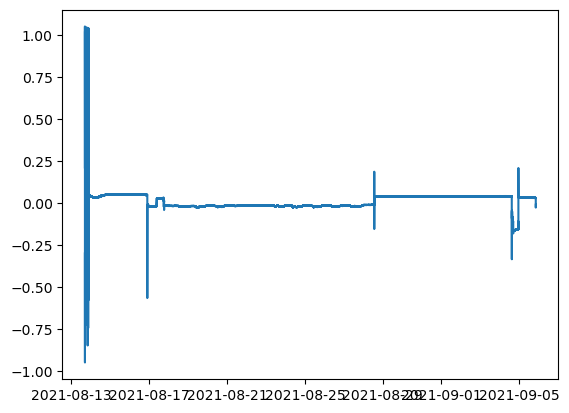

In [149]:
plt.plot(moving_mean_df['time'], moving_mean_df['X_mean'])
plt.show()

In [131]:
    # Compute the moving standard deviation for each window
moving_std_df = (
        trimmed_df.lazy()
        .with_row_index()
        .with_columns((pl.col('index') / samples_per_window).cast(pl.Int32).alias('window'))
        .group_by('window')
        .agg([
            pl.col('time').first().alias('window_start'),
            pl.all().exclude(['time', 'index']).std().name.suffix('_std')
        ])
        .sort('window')
    ).collect()

In [133]:
moving_mean_df = (
        trimmed_df.lazy()
        .with_row_index()
        .with_columns((pl.col('index') / samples_per_window).cast(pl.Int32).alias('window'))
        .group_by('window')
        .agg([
            pl.col('time').first().alias('window_start'),
            pl.all().exclude(['time', 'index']).mean().name.suffix('_mean')
        ])
        .sort('window')
    ).collect()

In [ ]:
import sklearn.linear_model

In [150]:
test_data.acceleration.height

119984400

In [156]:
acc_sd = moving_std_df.select(['X_std', 'Y_std', 'Z_std'])
acc_rm = moving_std_df.select(['X_mean', 'Y_mean', 'Z_mean'])

In [169]:
sd_crit = 0.013
no_motion = np.all(acc_sd < sd_crit, axis=1) & np.all(np.abs(acc_rm) < 2, axis=1)

In [170]:
np.abs(acc_rm) <2

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [161]:
acc_sd_nm = acc_sd.filter(no_motion)